# Explore how confidently bases are called; i.e. how close to 1.0 is the within-sample allele frequency (WSAF) for each base call?
---

In [1]:
import os
import sys
import configparser
import getopt
import numpy as np
import pandas as pd
from collections import Counter

from lib.error import *

In [37]:
from matplotlib import lines
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [4, 4]

## 0 Settings

In [3]:
expt_dir = "../analysis/ont/zambia/2019-04-10"  # experiment of interest
cntrl_sample = "BC05"  # 3d7 sample

If `save_figs` is set to `True`, then figures are automatically saved as `.png` under `../figs`, as well as visualized in the notebook.

In [4]:
save_figs = True
fig_dir = expt_dir.replace("analysis", "figs")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [5]:
print("Make Figures:", save_figs)
print("Figure path:", fig_dir)

Make Figures: True
Figure path: ../figs/ont/zambia/2019-04-10


## 1 Call confidence including indels

In [13]:
kelch = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".KELCH13.reverse.nt_error.csv"))
kelch = convert_to_frequencies(kelch, "total", ["position", "ref", "total"])

In [14]:
dhfr = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".DHFR.nt_error.csv"))
dhfr = convert_to_frequencies(dhfr, "total", ["position", "ref", "total"])

In [15]:
crt = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".CRT.nt_error.csv"))
crt.query("total > 1", inplace=True)
crt = convert_to_frequencies(crt, "total", ["position", "ref", "total"])

In [16]:
msp = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".MSP2.reverse.nt_error.csv"))
msp = convert_to_frequencies(msp, "total", ["position", "ref", "total"])

In [17]:
genes = [kelch, dhfr, crt, msp]
gene_df = pd.concat(genes)

### 1a Find first and second highest WSAF

In [33]:
bases = ["A", "T", "C", "G", "+", "-"]
gene_df["call"] = gene_df[bases].idxmax(1)
gene_df["second_call"] = [row[[b for b in bases if b != row["call"]]]
                          .astype('float')
                          .idxmax(1)
                          for ix, row in gene_df.iterrows()]

In [35]:
gene_df["call_wsaf"] = [row[row["call"]] for ix, row in gene_df.iterrows()]
gene_df["second_call_wsaf"] = [row[row["second_call"]] for ix, row in gene_df.iterrows()]

Text(0.5,0.98,'Including Indels')

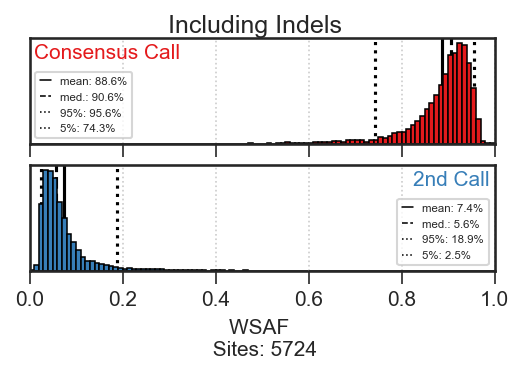

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(4, 2), sharex=True)
fig.subplots_adjust(top=0.9)

params = {
    "call_wsaf": "Consensus Call",
    "second_call_wsaf": "2nd Call"
}

bs = np.arange(0, 1.01, 0.01)
cols = sns.color_palette("Set1", 2)
for (p, name), (col, ax) in zip(params.items(), zip(cols, axes.flatten())):
    
    values = gene_df[p]
    stats = {
        "mean": (values.mean(), "solid"),
        "med.": (values.median(), "dashed"),
        "95%": (values.quantile(q=0.95), "dotted"),
        "5%": (values.quantile(q=0.05), "dotted")
    }
    
    # Plot
    ax.hist(values, bins=bs, color=col, 
            edgecolor='black', linewidth=0.75)
    
    ax.grid(linestyle='dotted')
    
    # Axis
    ax.yaxis.set_visible(False)
    
    # Lines
    for stat, (val, ls) in stats.items():
        ax.axvline(val, color="black", linestyle=ls, label=stat, zorder=0)
    
    # Legend
    handles = [lines.Line2D([0], [0],
                            linestyle=ls, color='black',
                            linewidth=0.75,
                            label="%s: %.01f%%" % (stat, 100*val)) 
               for stat, (val, ls) in stats.items()]
    if stats["mean"][0] > 0.5:
        legend_loc = "lower left"
        annot_loc = [(0.01, 0.95), "left"]
    else:
        legend_loc = "lower right"
        annot_loc = [(0.99, 0.95), "right"]
    
    ax.legend(loc=legend_loc, handles=handles, handlelength=1.0,
              fontsize=5.5, frameon=True)
    
    
    # Title
    ax.annotate(xy=annot_loc[0], xycoords="axes fraction",
                ha=annot_loc[1], va="top",
                color=col,
                s=name)
    ax.set_xlim((0, 1.0))
    
ax.set_xlabel("WSAF \n Sites: %d" % len(gene_df))
fig.suptitle("Including Indels")

if save_figs:
    fig.savefig(os.path.join(fig_dir, "nt_call_confidence_including_indels.png"),
                bbox_inches="tight",
                pad_inches=0.5)

## 2 Call confidence excluding indels

In [77]:
bases = ["A", "T", "C", "G"]

In [78]:
kelch = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".KELCH13.reverse.nt_error.csv"))
kelch.drop(["total", "-", "+", "error"], 1, inplace=True)
kelch["total"] = kelch[bases].sum(1)
kelch = convert_to_frequencies(kelch, "total", ["position", "ref", "total"])

In [79]:
dhfr = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".DHFR.nt_error.csv"))
dhfr.drop(["total", "-", "+", "error"], 1, inplace=True)
dhfr["total"] = dhfr[bases].sum(1)
dhfr = convert_to_frequencies(dhfr, "total", ["position", "ref", "total"])

In [80]:
crt = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".CRT.nt_error.csv"))
crt.query("total > 1", inplace=True)
crt.drop(["total", "-", "+", "error"], 1, inplace=True)
crt["total"] = crt[bases].sum(1)
crt = convert_to_frequencies(crt, "total", ["position", "ref", "total"])

In [82]:
msp = pd.read_csv(os.path.join(expt_dir, cntrl_sample + ".MSP2.reverse.nt_error.csv"))
msp.drop(["total", "-", "+", "error"], 1, inplace=True)
msp["total"] = msp[bases].sum(1)
msp = convert_to_frequencies(msp, "total", ["position", "ref", "total"])

In [83]:
genes = [kelch, dhfr, crt, msp]
gene_df = pd.concat(genes)

### 2a Find first and second highest WSAF

In [84]:
gene_df["call"] = gene_df[bases].idxmax(1)
gene_df["second_call"] = [row[[b for b in bases if b != row["call"]]]
                          .astype('float')
                          .idxmax(1)
                          for ix, row in gene_df.iterrows()]

In [85]:
gene_df["call_wsaf"] = [row[row["call"]] for ix, row in gene_df.iterrows()]
gene_df["second_call_wsaf"] = [row[row["second_call"]] for ix, row in gene_df.iterrows()]

Text(0.5,0.98,'Ignoring Indels')

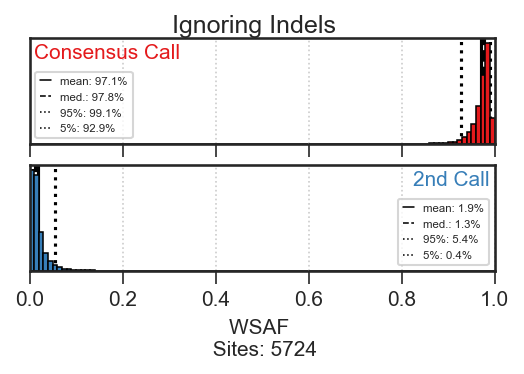

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(4, 2), sharex=True)
fig.subplots_adjust(top=0.9)

params = {
    "call_wsaf": "Consensus Call",
    "second_call_wsaf": "2nd Call"
}

bs = np.arange(0, 1.01, 0.01)
cols = sns.color_palette("Set1", 2)
for (p, name), (col, ax) in zip(params.items(), zip(cols, axes.flatten())):
    
    values = gene_df[p]
    stats = {
        "mean": (values.mean(), "solid"),
        "med.": (values.median(), "dashed"),
        "95%": (values.quantile(q=0.95), "dotted"),
        "5%": (values.quantile(q=0.05), "dotted")
    }
    
    # Plot
    ax.hist(values, bins=bs, color=col, 
            edgecolor='black', linewidth=0.75)
    
    ax.grid(linestyle='dotted')
    
    # Axis
    ax.yaxis.set_visible(False)
    
    # Lines
    for stat, (val, ls) in stats.items():
        ax.axvline(val, color="black", linestyle=ls, label=stat, zorder=0)
    
    # Legend
    handles = [lines.Line2D([0], [0],
                            linestyle=ls, color='black',
                            linewidth=0.75,
                            label="%s: %.01f%%" % (stat, 100*val)) 
               for stat, (val, ls) in stats.items()]
    if stats["mean"][0] > 0.5:
        legend_loc = "lower left"
        annot_loc = [(0.01, 0.95), "left"]
    else:
        legend_loc = "lower right"
        annot_loc = [(0.99, 0.95), "right"]
    
    ax.legend(loc=legend_loc, handles=handles, handlelength=1.0,
              fontsize=5.5, frameon=True)
    
    
    # Title
    ax.annotate(xy=annot_loc[0], xycoords="axes fraction",
                ha=annot_loc[1], va="top",
                color=col,
                s=name)
    ax.set_xlim((0, 1.0))
    
ax.set_xlabel("WSAF \n Sites: %d" % len(gene_df))
fig.suptitle("Ignoring Indels")

if save_figs:
    fig.savefig(os.path.join(fig_dir, "nt_call_confidence_excluding_indels.png"),
                bbox_inches="tight",
                pad_inches=0.5)

### 2b Ratio between consensus and second call

In [98]:
gene_df["ratio"] = gene_df["call_wsaf"]/gene_df["second_call_wsaf"]
gene_df.sort_values("ratio", inplace=True)

In [99]:
gene_df.head()

,position,ref,total,A,T,C,G,SNV,call,second_call,call_wsaf,second_call_wsaf,ratio
581,581,C,3513,0.126388,0.262738,0.569029,0.041845,0.430971,C,T,0.569029,0.262738,2.165764
2159,2159,C,7632,0.034067,0.262841,0.697327,0.005765,0.302673,C,T,0.697327,0.262841,2.653041
717,717,G,7164,0.224595,0.013121,0.000838,0.761446,0.238554,G,A,0.761446,0.224595,3.390305
950,950,C,7422,0.002829,0.220291,0.772029,0.004850,0.227971,C,T,0.772029,0.220291,3.504587
394,394,C,7536,0.015260,0.198116,0.784766,0.001858,0.215234,C,T,0.784766,0.198116,3.961152


Is this correct? At the *worst* site; we are still 2x higher for the consensus call?

In [110]:
def calc_sites_below_ratio(df, min_ratio):
    """
    Get the fraction of all sites
    with a `call_wsaf`/`second_call_wsaf` 
    ratio less than `ratio`
    """
    return len(df.query("ratio <= @min_ratio"))/len(df)

In [162]:
def calc_ratio_below_frac(df, frac):
    """
    Get the ratio whereby `frac` of sites
    have a lower ratio
    """
    n_sites = len(df)
    n_frac_sites = int(n_sites*frac)
    return df.iloc[n_frac_sites]["ratio"]

Text(75.8416,1,'75.84')

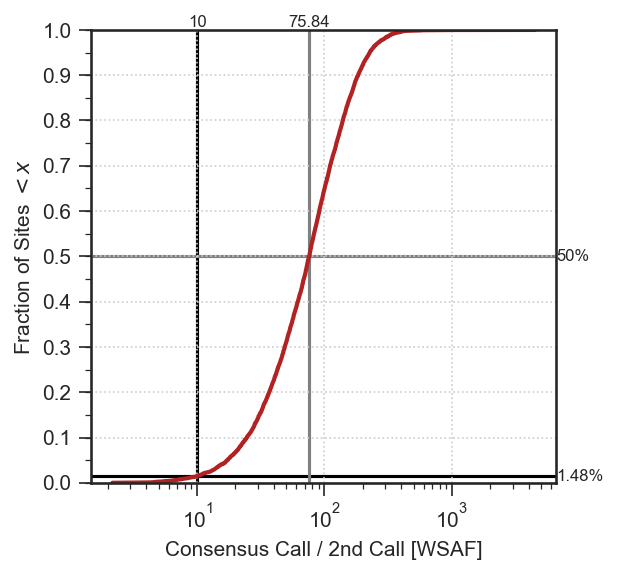

In [173]:
fig, ax = plt.subplots(1, 1)

# Plot
frac = np.arange(1, len(gene_df)+1)/len(gene_df)
ax.plot(gene_df["ratio"], frac, '-', linewidth=2, color='firebrick')
# Scale
ax.set_xscale("log")
# Limits
ax.set_ylim((0, 1.0))
# Labels
ax.set_xlabel("Consensus Call / 2nd Call [WSAF]")
ax.set_ylabel("Fraction of Sites $< x$")
# Grid
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.grid(linestyle='dotted')

# What percentage of data has < 10x?
less_10 = calc_sites_below_ratio(gene_df, 10)
ax.axvline(x=10, color='black', zorder=0)
ax.axhline(y=less_10, color='black', zorder=0)
ax.text(x=ax.get_xlim()[1], y=less_10,
        ha="left", va="center", fontsize=8,
        s="%.02f%%" % (100*less_10))
ax.text(x=10, y=ax.get_ylim()[1],
        ha="center", va="bottom", fontsize=8,
        s=10)

# Half of the data has a ratio greater than X?
X = calc_ratio_below_frac(gene_df, 0.5)
ax.axhline(y=0.5, linestyle="solid", color='grey', zorder=0)
ax.axvline(x=X, linestyle="solid", color='grey', zorder=0)
ax.text(x=ax.get_xlim()[1], y=0.5,
        ha="left", va="center", fontsize=8,
        s="50%")
ax.text(x=X, y=ax.get_ylim()[1],
        ha="center", va="bottom", fontsize=8,
        s="%.02f" % X)

if save_figs:
    fig.savefig(os.path.join(fig_dir, "nt_call_confidence_excluding_indels_ratio.png"),
                bbox_inches="tight",
                pad_inches=0.5)

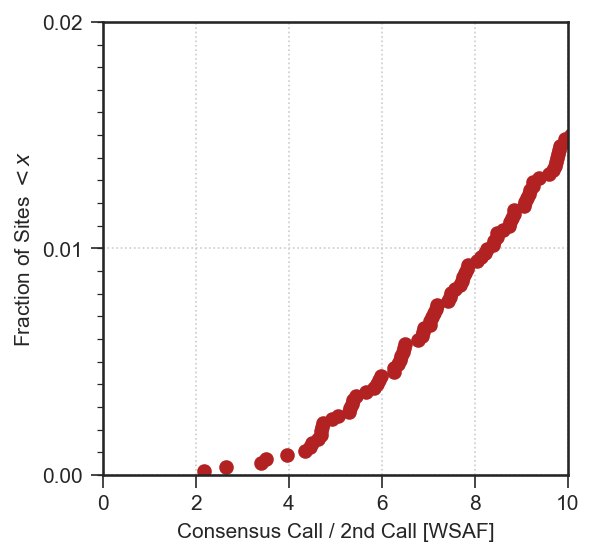

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot
frac = np.arange(1, len(gene_df)+1)/len(gene_df)
ax.plot(gene_df["ratio"], frac, 'o', color='firebrick')
# Scale
#ax.set_xscale("log")
# Limits
ax.set_ylim((0, 0.02))
ax.set_xlim((0, 10))
# Labels
ax.set_xlabel("Consensus Call / 2nd Call [WSAF]")
ax.set_ylabel("Fraction of Sites $< x$")
# Grid
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.001))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.grid(linestyle='dotted')

if save_figs:
    fig.savefig(os.path.join(fig_dir, "nt_call_confidence_excluding_indels_ratio_zoom.png"),
                bbox_inches="tight",
                pad_inches=0.5)

Could reasonably conclude there really are no bad sites here. But need to compare this to IGV results.